#Big Data - Binary Classification
Dataset: https://www.kaggle.com/mitishaagarwal/patient

Implemented using: Apache Spark

Model: Dimensionality Reduction (PCA) + Logistic Regression

Metric: Accuracy (BinaryClassificationEvaluator)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.3-bin-hadoop2.7/
spark-3.0.3-bin-hadoop2.7/NOTICE
spark-3.0.3-bin-hadoop2.7/kubernetes/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/Dockerfile
spark-3.0.3-bin-hadoop2.7/jars/
spark-3.0.3-bin-hadoop2.7/jars/jacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab/Patient Survival/

/content/drive/My Drive/Colab/Patient Survival


# Create Spark Session

In [ ]:
from pyspark.sql import SparkSession

session = SparkSession.builder.getOrCreate()

#Read the dataset

In this dataset, there are various factors given, which are involved when a patient is hospitalized. On the basis of these factors, predict whether the patient will survive or not.

In [ ]:
dataset = session.read.csv("dataset.csv", header = True, inferSchema = True)
dataset

DataFrame[encounter_id: int, patient_id: int, hospital_id: int, age: int, bmi: double, elective_surgery: int, ethnicity: string, gender: string, height: double, icu_admit_source: string, icu_id: int, icu_stay_type: string, icu_type: string, pre_icu_los_days: double, weight: double, apache_2_diagnosis: int, apache_3j_diagnosis: double, apache_post_operative: int, arf_apache: int, gcs_eyes_apache: int, gcs_motor_apache: int, gcs_unable_apache: int, gcs_verbal_apache: int, heart_rate_apache: int, intubated_apache: int, map_apache: int, resprate_apache: double, temp_apache: double, ventilated_apache: int, d1_diasbp_max: int, d1_diasbp_min: int, d1_diasbp_noninvasive_max: int, d1_diasbp_noninvasive_min: int, d1_heartrate_max: int, d1_heartrate_min: int, d1_mbp_max: int, d1_mbp_min: int, d1_mbp_noninvasive_max: int, d1_mbp_noninvasive_min: int, d1_resprate_max: int, d1_resprate_min: int, d1_spo2_max: int, d1_spo2_min: int, d1_sysbp_max: int, d1_sysbp_min: int, d1_sysbp_noninvasive_max: int, 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import plotly.express as px
import plotly.offline as oy
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score,
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#Data Understanding

Disini kita plot heatmap correlation untuk mengetahui features mana saja yang relevant untuk memprediksi hospital_death

Juga kita plot age, gender, hospital_death, dan bmi yang relevant untuk orang umum memahami data

In [ ]:
df = pd.read_csv("dataset.csv")

fig = px.histogram(df[['age', 'gender', 'hospital_death', 'bmi']].dropna(), x= "age", y = "hospital_death", color = 'gender',
                  marginal = 'box', hover_data = df[['age', 'gender', 'hospital_death', 'bmi']].columns)
fig.show()

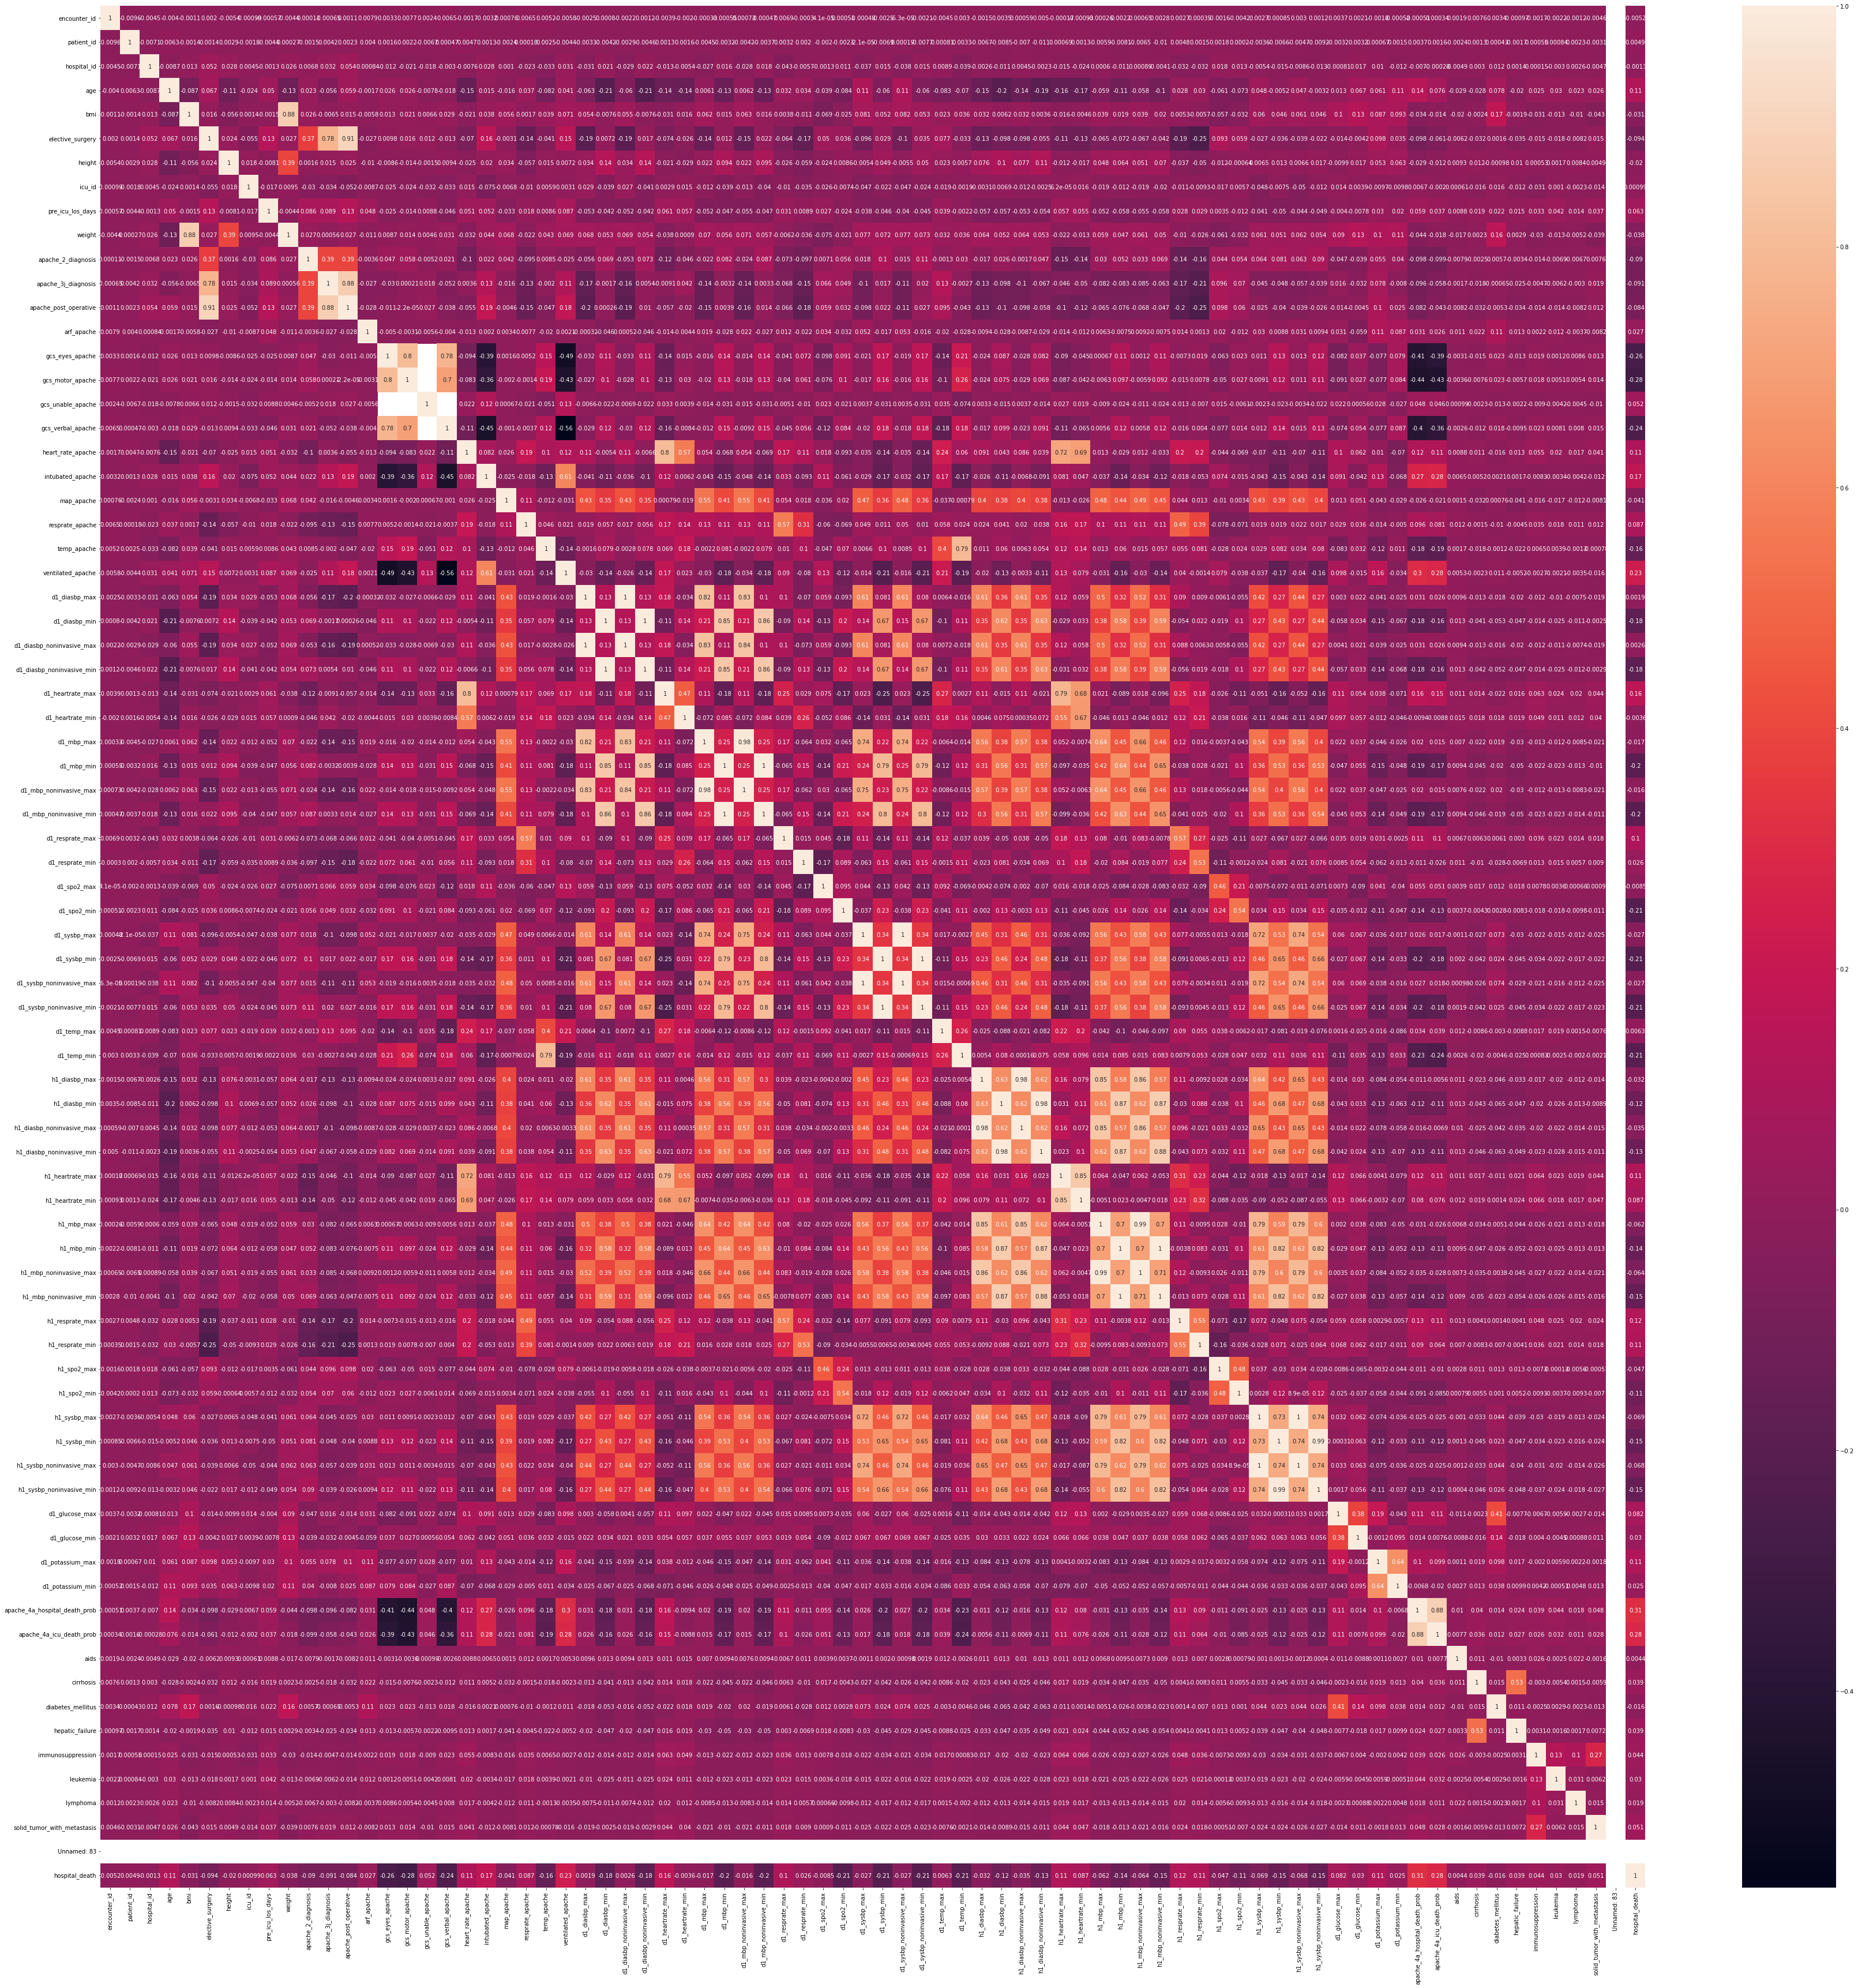

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(60,60))
sns.heatmap(df.corr(), annot=True)

Namun bisa dilihat bahwa features cukup banyak yang relevant, maka kami akan mencoba teknik PCA untuk dimensionality reduction

#Dataset Preprocessing

Let's drop some id and irrelevant feature,

drop ethnicity, bodysystem, icu_type, c83 because currently cannot tell the relation-correlation, variant, and scale between the string value

In [ ]:
dataset = dataset.drop("ethnicity", "encounter_id","patient_id", "hospital_id", "icu_admit_source",
             "icu_id", "icu_stay_type", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem", "_c83")

In [ ]:
dataset.show()

+---+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+-------------

Drop all row that has null value

In [ ]:
dataset = dataset.na.drop()

In [ ]:
dataset.show()

+---+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+-------------

Numerize the gender value into 0 and 1 to make sure it can be computed by PCA and Logistic Regression

In [ ]:
from pyspark.sql.functions import when

dataset = dataset.withColumn("gender", when(dataset["gender"] == "M", 0).
                                          when(dataset["gender"] == "F", 1))

In [ ]:
dataset.show()

+---+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+-------------

Set all the datatype into double

In [ ]:
from pyspark.sql.functions import col

cols = dataset.columns

for col_name in cols:
    dataset = dataset.withColumn(col_name, col(col_name).cast('double'))

Scale the value for each column using Standard Scaler

In spark, we have to merge the column using vector assembler

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

cols = dataset.columns
cols.remove("hospital_death")

dataset = VectorAssembler(inputCols = cols, outputCol = "feature").transform(dataset)

In [ ]:
scaler = StandardScaler(inputCol = "feature", outputCol = "scaled_feature")
dataset = scaler.fit(dataset).transform(dataset)

# scaler = StandardScaler(inputCol = "feature", outputCol = "features")
# dataset = scaler.fit(dataset).transform(dataset)

In [ ]:
dataset.show()

+----+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+------------

Apply PCA, with selected features k = 40

Principal component analysis (PCA) is a statistical method to find a rotation such that the first coordinate has the largest variance possible, and each succeeding coordinate, in turn, has the largest variance possible. The columns of the rotation matrix are called principal components. PCA is used widely in dimensionality reduction.

We chose to use PCA as we know that the column/dimension is as many as more than 80 and as a non medical student we can't decide which features is relevant and which is not, thus we use PCA to let it choose for us.

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=40, inputCol = "scaled_feature", outputCol="features")

model = pca.fit(dataset)
dataset = model.transform(dataset)
dataset.show()

+----+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+------------

Split the dataset into train (75%) and test (25%)

Train data: 43300 datas

Test data: 14296 datas

In [ ]:
temp = dataset.randomSplit([0.75, 0.25])

In [ ]:
temp[0].count()

43026

In [ ]:
temp[1].count()

14570

Build the model of Logistic Regression

And the metric accuracy using Binary Classification Evaluator

Logistic regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. In spark.ml logistic regression can be used to predict a binary outcome by using binomial logistic regression. We chose logistic regression due to it is one of the best model to predict binary classification as we already tested other models and the result doesn't come as close as Logistic Regression

Binary classifiers are used to separate the elements of a given dataset into one of two possible groups (e.g. fraud or not fraud) and is a special case of multiclass classification. Most binary classification metrics can be generalized to multiclass classification metrics.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train = temp[0]
test = temp[1]

model = LogisticRegression(featuresCol = "features", labelCol = "hospital_death", maxIter = 100).fit(train)
train_pred = model.transform(train)
prediction = model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol = "hospital_death")

print("Test Accuracy: {}%".format(evaluator.evaluate(prediction) * 100))

Test Accuracy: 85.97976506441424%


In [ ]:
print("Train Accuracy: {}%".format(evaluator.evaluate(train_pred) * 100))

Train Accuracy: 86.03310976642067%


In [ ]:
prediction = prediction.toPandas()

In [ ]:
prediction[['hospital_death', 'prediction']].tail(100)

hospital_death  prediction
14470             0.0         0.0
14471             0.0         0.0
14472             0.0         0.0
14473             0.0         0.0
14474             0.0         0.0
...               ...         ...
14565             0.0         0.0
14566             0.0         0.0
14567             0.0         0.0
14568             0.0         0.0
14569             1.0         0.0

[100 rows x 2 columns]

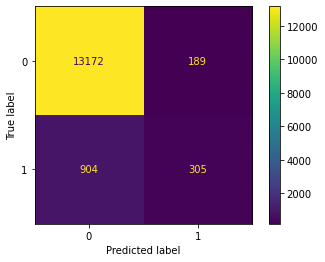

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(prediction['hospital_death'], prediction['prediction'])

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])

cmd_obj.plot()

plt.show()

#Summary

The model successfully predicted the state of the patient with accuracy of ~85% to 86% using Logistic Regression, selected features by PCA, and Standard Scaler normalization and preprocessing